In [1]:
%matplotlib inline

import os
import json
import math
import sys
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import xgboost as xgb
import shap
import datetime
import warnings
warnings.filterwarnings("ignore")

notebook_path = !pwd
prj_path = os.path.abspath(os.path.join(notebook_path[0], '../', ''))
sys.path.append(prj_path)
print('Added: %s' % prj_path)

In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in 

Added: /Users/lsanchez/omath_mota_rulo


In [2]:
from data_scientia.features import train_data
from data_scientia.models.eval import eval_utils

In [3]:
data = train_data.get()

data.shape

(10589, 32)

In [13]:
target = 'is_next_peak_in_15_days'
forbiden = [
    'is_next_peak_in_7_days', 
    'is_next_peak_in_15_days', 
    'is_next_peak_in_20_days', 
    'is_next_peak_in_30_days'
] + [
    x 
    for x in data.columns
    if 'neighbor_hosp' in x]

oot_size = .2
train_boundary = data['fecha'].quantile(1 - oot_size)
oot = data[data['fecha'] >= train_boundary]
train = data[data['fecha'] < train_boundary]

oos_size = .3
val_boundary = train['fecha'].quantile(1 - oos_size)

val = train[train['fecha'] >= val_boundary]
train = train[train['fecha'] < val_boundary]

In [14]:
X_train = train.set_index(['fecha', 'nombre_hospital']).drop(forbiden, axis=1)
y_train = train.set_index(['fecha', 'nombre_hospital'])[target]

X_val = val.set_index(['fecha', 'nombre_hospital']).drop(forbiden, axis=1)
y_val = val.set_index(['fecha', 'nombre_hospital'])[target]

X_oot = oot.set_index(['fecha', 'nombre_hospital']).drop(forbiden, axis=1)
y_oot = oot.set_index(['fecha', 'nombre_hospital'])[target]

In [15]:
print(data.shape[0], X_train.shape[0], X_val.shape[0], X_oot.shape[0])

10589 5868 2562 2159


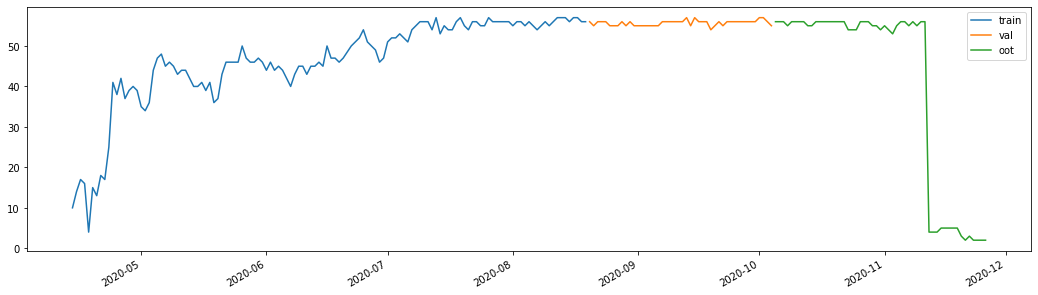

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))

data_plot = X_train.reset_index()['fecha'].value_counts()
data_plot.name = 'train'
data_plot.plot(
    legend=True,
    ax=ax)

data_plot = X_val.reset_index()['fecha'].value_counts()
data_plot.name = 'val'
data_plot.plot(
    legend=True, 
    ax=ax)

data_plot = X_oot.reset_index()['fecha'].value_counts()
data_plot.name = 'oot'
data_plot.plot(
    legend=True, 
    ax=ax)

In [21]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = xgb.XGBClassifier(
    subsample=.5,
    max_depth=3,
    learning_rate=.01,
    scale_pos_weight=scale_pos_weight
)

model.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric=['logloss', 'auc'],
    early_stopping_rounds=10,
    verbose=False)

y_train_score = model.predict_proba(X_train)
y_val_score = model.predict_proba(X_val)
y_oot_score = model.predict_proba(X_oot)

# Evaluate
print(eval_utils.classification_report(
    y_true=y_train, 
    y_score=y_train_score, 
    y_pred=(y_train_score[:, 1] > .5).astype(int)))

print(eval_utils.classification_report(
    y_true=y_val, 
    y_score=y_val_score, 
    y_pred=(y_val_score[:, 1] > .5).astype(int)))

print(eval_utils.classification_report(
    y_true=y_oot, 
    y_score=y_oot_score, 
    y_pred=(y_oot_score[:, 1] > .5).astype(int)))

             precision    recall  f1-score  support    pred       AUC
0             0.906069  0.704653  0.792768   4449.0  3460.0  0.809443
1             0.454319  0.770965  0.571727   1419.0  2408.0  0.809443
avg / total   0.796827  0.720688  0.739316   5868.0  5868.0  0.809443
             precision    recall  f1-score  support    pred       AUC
0             0.967064  0.696809  0.809988   2444.0  1761.0  0.644142
1             0.074906  0.508475  0.130577    118.0   801.0  0.644142
avg / total   0.925973  0.688134  0.778696   2562.0  2562.0  0.644142
             precision    recall  f1-score  support    pred       AUC
0             0.962025  0.306916  0.465365   1981.0   632.0  0.645333
1             0.100851  0.865169  0.180645    178.0  1527.0  0.645333
avg / total   0.891025  0.352941  0.441892   2159.0  2159.0  0.645333


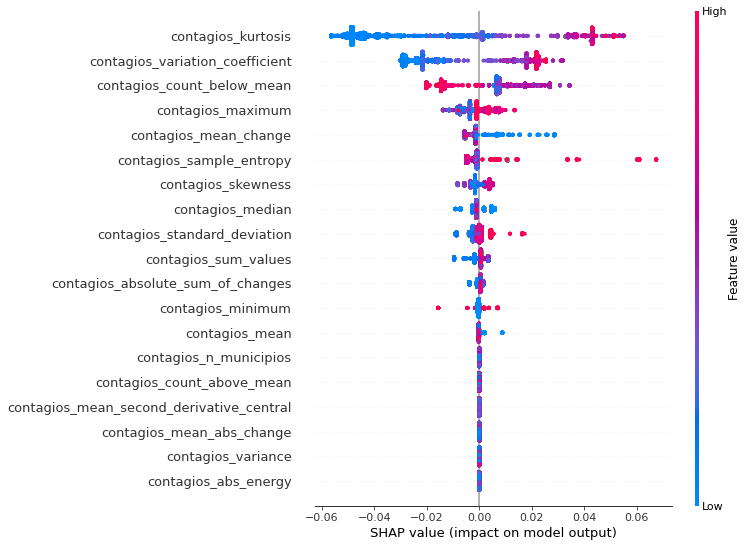

In [22]:
explainer = shap.TreeExplainer(model)
    
shaps_values = pd.DataFrame(
    explainer.shap_values(X_train),
    columns=X_train.columns)

shap.summary_plot(
    shaps_values.values, 
    X_train,
    max_display=1000)